In [2]:
import cv2
import numpy as np
import pandas as pd

In [3]:
data_dir = '../data'

In [ ]:
import random

# Input: List of patient_id
# Output: Tuple of (train_patient_ids, val_patient_ids)
# train_ratio: Ratio of training set
def train_val_split(patients: pd.DataFrame, train_ratio: float = 0.8) -> (pd.DataFrame, pd.DataFrame):
  patient_ids = patients['Patient'].unique()
  random.shuffle(patient_ids)

  train_patients = patients[patients['Patient'].isin(patient_ids[:int(len(patient_ids) * train_ratio)])]
  val_patients = patients[patients['Patient'].isin(patient_ids[int(len(patient_ids) * train_ratio):])]

  return train_patients, val_patients

In [5]:
# Prepare train and val data
train_patients = pd.read_csv(data_dir + '/train.csv')
test_patients = pd.read_csv(data_dir + '/test.csv')

# Remove row in train data if patient_id is in test_patient_ids
train_patients = train_patients[~train_patients['Patient'].isin(test_patients)]

train_patients, val_patients = train_val_split(train_patients)

# Sort df by patient and then by 'Weeks'
train_patients = train_patients.sort_values(by=['Patient', 'Weeks'])

# Group by patient and get the first FVC value
patient_id_to_initial_FVC = train_patients.groupby('Patient')['FVC'].first().to_dict()

In [6]:
# Edge detection using Sobel operator
def extract_edge(image_array):
  edgesX = cv2.Sobel(image_array, cv2.CV_64F, 1, 0, ksize=3)
  edgesY = cv2.Sobel(image_array, cv2.CV_64F, 0, 1, ksize=3)
  absEdgesX = cv2.convertScaleAbs(edgesX)
  absEdgesY = cv2.convertScaleAbs(edgesY)
  edges = cv2.addWeighted(absEdgesX, 0.5, absEdgesY, 0.5, 0)
  return edges

In [7]:
def extract_corner(image_array):
  # Apply cornerHarris
  score = cv2.cornerHarris(image_array, 2, 3, 0.04)
  # 0.05 is a threshold to determine if a corner is valid
  corners = score > 0.05 * score.max()

  # Could consider returning original score without thresholding
  return corners


In [8]:
def extract_blob(image_array):
  # Use DoG (Difference of Gaussian) to detect blobs
  # First, apply GaussianBlur to the image
  blurred1 = cv2.GaussianBlur(image_array, (5, 5), 0)
  blurred2 = cv2.GaussianBlur(image_array, (11, 11), 0)

  # Then, compute the difference between the blurred image and the original image
  dog = cv2.subtract(blurred1, blurred2)

  # minmax normalize the result to enhance contrast
  dog = cv2.normalize(dog, None, 0, 255, cv2.NORM_MINMAX)

  return dog

In [9]:
def extract_local_binary_pattern(image_array):
  # Get image dimensions
  height, width = image_array.shape

  # Initialize LBP image
  lbp_image = np.zeros_like(image_array)

  # Define 8-neighborhood offsets (8-connected)
  offsets = [(-1, -1), (-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1)]

  # Apply LBP to each pixel (excluding border pixels)
  for i in range(1, height - 1):
    for j in range(1, width - 1):
      center_pixel = image_array[i, j]
      binary_pattern = 0

      # Compare center pixel with 8 neighbors
      for k, (di, dj) in enumerate(offsets):
        neighbor_pixel = image_array[i + di, j + dj]
        if neighbor_pixel >= center_pixel:
          binary_pattern |= (1 << k)

      lbp_image[i, j] = binary_pattern

  return lbp_image


In [10]:
def extract_gabor_feature(image_array):
  # Define Gabor filter parameters
  orientations = [0, 45, 90, 135]  # 4 orientations in degrees
  frequencies = [0.1, 0.2, 0.3]   # 3 different frequencies
  sigma = 2.0  # Standard deviation of Gaussian envelope
  gamma = 0.5  # Spatial aspect ratio

  # Initialize feature maps
  gabor_features = []

  # Apply Gabor filters with different orientations and frequencies
  for orientation in orientations:
    for frequency in frequencies:
      # Convert orientation to radians
      theta = np.radians(orientation)

      # Create Gabor kernel
      kernel = cv2.getGaborKernel(
        ksize=(15, 15),  # Kernel size
        sigma=sigma,
        theta=theta,
        lambd=1.0/frequency,  # Wavelength
        gamma=gamma,
        psi=0,  # Phase offset
        ktype=cv2.CV_32F
      )

      # Apply filter
      filtered = cv2.filter2D(image_array, cv2.CV_32F, kernel)

      # Take magnitude of response
      magnitude = np.abs(filtered)

      # Normalize to 0-255 range
      magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

      gabor_features.append(magnitude)

  # Combine all Gabor responses (mean of all filter responses)
  combined_gabor = np.mean(gabor_features, axis=0)

  return combined_gabor


In [11]:
import pydicom

# Read indivudal scans from DICOM files
def read_dicom(path):
  dicom = pydicom.dcmread(path)
  # Convert image to float32
  image_array = np.float32(dicom.pixel_array)
  return image_array

In [ ]:
import os
import pandas as pd
from concurrent.futures import ProcessPoolExecutor

from preprocess import preprocess_dicom

tabular = pd.read_csv('../data/train.csv')
patient_ids = tabular['Patient'].unique()

def get_patient_scans_path(patient_id):
  dir_size = len(os.listdir(f'../data/train/{patient_id}/'))
  return [f'../data/train/{patient_id}/{i}.dcm' for i in range(1, dir_size + 1)]

def load_patient_scans(patient_id):
  scan_paths = get_patient_scans_path(patient_id)
  patient_scans = []

  for scan_path in scan_paths:
    try:
      dcm = pydicom.dcmread(scan_path)
      # Use process executor pool to preprocess dicom
      # with ProcessPoolExecutor(max_workers=4) as executor:
      #   preprocessed_scan = executor.submit(preprocess_dicom, dcm).result()
      preprocessed_scan = preprocess_dicom(dcm)
      patient_scans.append(preprocessed_scan)
    except:
      raise Exception(f'Error reading {patient_id}')
  patient_scans = np.array(patient_scans, dtype=np.float32)
  return patient_scans

In [13]:
def extract_features(scan):
  features = []
  features.append(extract_edge(scan))
  features.append(extract_corner(scan))
  features.append(extract_blob(scan))
  features.append(extract_local_binary_pattern(scan))
  features.append(extract_gabor_feature(scan))
  return features

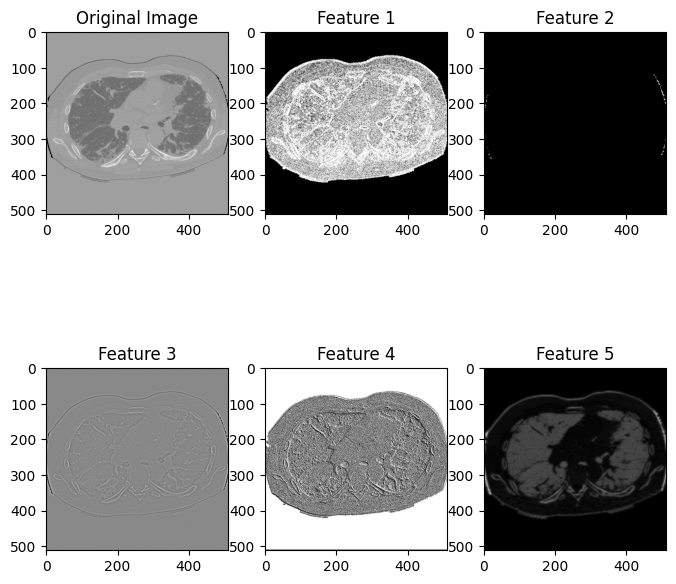

In [14]:
import matplotlib.pyplot as plt

patient_id = train_patients.iloc[0].Patient
scans = load_patient_scans(patient_id)
features = extract_features(scans[15])

# Compare original image to features
fig, axs = plt.subplots(2, 3, figsize=(8, 8))
axs[0][0].imshow(scans[15], cmap='gray')
axs[0][0].set_title('Original Image')
for row in range(2):
  for col in range(3):
    if row == 0 and col == 0:
      continue
    axs[row][col].imshow(features[row * 3 + col - 1], cmap='gray')
    axs[row][col].set_title(f'Feature {row * 3 + col}')
plt.show()

### Approach 1: Use random forest to regress on individual scan and individual features

In [22]:
x_train = []
y_train = []

no_scan_patient_ids = set()

for row in train_patients.itertuples():
  patient_id = row.Patient
  if patient_id in no_scan_patient_ids:
    continue
  try:
    scan_paths = get_patient_scans_path(patient_id)
  except Exception as e:
    if patient_id not in no_scan_patient_ids:
      no_scan_patient_ids.add(patient_id)
      print(e)
    continue

  for i in range(len(scan_paths)):
    x_train.append({
      'patient_id': patient_id,
      'scan_index': i,
      'scan_positional_ratio': round((i+1) / len(scan_paths), 4),
      'initial_FVC': patient_id_to_initial_FVC[patient_id],
      'week': row.Weeks
    })
    y_train.append(row.FVC)

x_train = pd.DataFrame(x_train)
y_train = pd.Series(y_train)

In [23]:
x_train

,patient_id,scan_index,scan_positional_ratio,initial_FVC,week
0,ID00007637202177411956430,0,0.0333,2315,-4
1,ID00007637202177411956430,1,0.0667,2315,-4
2,ID00007637202177411956430,2,0.1000,2315,-4
3,ID00007637202177411956430,3,0.1333,2315,-4
4,ID00007637202177411956430,4,0.1667,2315,-4
...,...,...,...,...,...
231409,ID00426637202313170790466,403,0.9902,2925,59
231410,ID00426637202313170790466,404,0.9926,2925,59
231411,ID00426637202313170790466,405,0.9951,2925,59
231412,ID00426637202313170790466,406,0.9975,2925,59


In [64]:
# Instantiate random forest regressor for each feature type
from sklearn.ensemble import RandomForestRegressor

# Initialize random forest regressor for each feature type
idx_to_feature_name = ['edge', 'corner', 'blob', 'lbp', 'gabor']
rf_regressors = [
  RandomForestRegressor(n_estimators=100, random_state=42)
  for _ in range(len(idx_to_feature_name))
]

# Train regressor by batch
def prepare_batch(x_dataset, y_dataset, batch_idx, batch_size=8):
  patient_ids = x_dataset[batch_idx:batch_idx+batch_size]['patient_id']
  scan_indexs = x_dataset[batch_idx:batch_idx+batch_size]['scan_index']
  scans = {
    patient_id: load_patient_scans(patient_id) for patient_id in patient_ids
  }
  scans = [scans[patient_id][scan_index] for patient_id, scan_index in zip(patient_ids, scan_indexs)]
  features = [extract_features(scan) for scan in scans]

  # Flatten each feature into scalars
  flattened_features = [[feature.flatten() for feature in scan] for scan in features]

  # Train each regressor on the training data
  batch_x = []
  batch_y = np.array(y_dataset[j:j+batch_size], dtype=np.float32)
  for i in range(len(idx_to_feature_name)):
    # Concat feature and metadata
    batch_x.append(np.array([np.concatenate((flattened_features[in_batch_idx][i], [x_dataset.iloc[j+in_batch_idx]['initial_FVC'].item(), x_dataset.iloc[j+in_batch_idx]['week'].item()])) for in_batch_idx in range(batch_size)], dtype=np.float32))
  batch_x = np.array(batch_x, dtype=np.float32)
  return batch_x, batch_y

max_epoch = 3
batch_size = 8

for epoch in range(max_epoch):
  for j in range(0, len(x_train), batch_size):
    batch_x, batch_y = prepare_batch(x_train, y_train, j, batch_size)
    for i in range(len(idx_to_feature_name)):
      rf_regressors[i].fit(batch_x[i], batch_y)

    if j % 80 == 0:
      print(f'Epoch {epoch} Batch {j} completed')

    # Use val set to evaluate model
    if j != 0 and j % 800 == 0:
      val_x, val_y = prepare_batch(x_train, y_train, 0, batch_size=len(x_train))
      predictions = []
      for i in range(len(rf_regressors)):
        predictions.append(rf_regressors[i].predict(val_x))
      predictions = np.array(predictions).T
      rmse = np.sqrt(np.mean((predictions - val_y) ** 2))
      print(f'Epoch {epoch} Batch {j} RMSE: {rmse}')
      break
  break

Process SpawnProcess-90:
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.12/3.12.11/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/homebrew/Cellar/python@3.12/3.12.11/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/homebrew/Cellar/python@3.12/3.12.11/Frameworks/Python.framework/Versions/3.12/lib/python3.12/concurrent/futures/process.py", line 252, in _process_worker
    call_item = call_queue.get(block=True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.12/3.12.11/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sangjunnam/Documents/Coding/CS3244/pulmonary_fibrosis/scan/preprocess.py"

Exception: Error reading ID00007637202177411956430